# Daily Financial News for 6000+ Stocks
### Some Data Understanding an Preparation for Prediction of stockpricse by the Sentiment of Headlines
@author DHR <br>
@author BKN <br>
used Data in this Notebook: 'https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests'

## Requirements

In [8]:
#immport basic DataScience Modules
#!! for pip-modul-list to install @see requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [9]:
#import basic topic modelling
import re
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import gensim

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

In [10]:
#import basic visualization
from wordcloud import WordCloud, STOPWORDS
import nltk #tokenization
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import random

[nltk_data] Downloading package stopwords to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#imports for generell Cleaning and Merging
import datetime

In [12]:
#imports headline cleaning
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dominik Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
#import basic api requirements
from polygon import RESTClient
import time
from dotenv import load_dotenv
load_dotenv()

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

In [14]:
#Load Data
data = pd.read_csv('../data/raw_analyst_ratings.csv')
#colums: id,headline,url,publisher,date,stock

## Data Understanding

Without Data Cleaning

In [15]:
#first Look
print(data.columns)
data.sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


id                                           headline  \
1079476  1084849  Stocks Which Set New 52-Week High Yesterday, A...   
1357        1759                          Transaction in Own Shares   
1221520  1227350   Hanover Reports Q2 Adj. EPS $1.69 vs. $1.58 Est.   
665121    668460  Credit Suisse Maintains Outperform on Ingredio...   
453863    456282  Benzinga Pro Mid-Day Price Check For Regional ...   
495522    498145  Morgan Stanley Maintains Overweight on Five Be...   
469872    472409     36 Stocks Moving In Thursday's Mid-Day Session   

                                                       url          publisher  \
1079476  https://www.benzinga.com/trading-ideas/technic...  Benzinga Newsdesk   
1357     https://www.benzinga.com/09/08/615/transaction...     Benzinga Staff   
1221520  https://www.benzinga.com/news/earnings/17/08/9...      Paul Quintaro   
665121   https://www.benzinga.com/news/18/05/11647673/c...         Vick Meyer   
453863   https://www.benzinga.com/news/global/18/06/118...  Benzinga Newsdesk   
495522   https://www.benzinga.com/news/19/10/14671914/m...         Vick Meyer   
469872   https://www.benzinga.com/news/20/01/15175164/3...         Lisa Levin   

                        date stock  
1079476  2018-08-09 00:00:00   RHI  
1357     2009-08-07 00:00:00     A  
1221520  2017-08-02 00:00:00   THG  
665121   2018-05-04 00:00:00  INGR  
453863   2018-06-01 00:00:00   EWJ  
495522   2019-10-28 00:00:00  FIVE  
469872   2020-01-23 00:00:00  EYES

In [16]:
#statistics
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))

observations: 1407328, features: 6 

unique headlines: 845770, unique stocks: 6204 



In [17]:
data.count()

id           1407328
headline     1407328
url          1407328
publisher    1407328
date         1407328
stock        1407328
dtype: int64

In [18]:
stock = data.groupby("stock")
stock.sample()

id                                           headline  \
818          824  J.P. Morgan Upgrades Agilent Tech To OW; PT Go...   
3191        3593         Alcoa Leads the Way for U.S. Stock Futures   
4254        4683  AAC Reaffirms FY17 Adj. EPS $0.50-$0.58 vs $0....   
4335        4764           3 ADR ETFs Your Broker Forgot to Mention   
4717        5157  American Air Reports Apr. RPMs Up 3.1% YoY, AS...   
...          ...                                                ...   
1405505  1412026             Stocks That Hit 52-Week Lows On Monday   
1406115  1412636  UPDATE: Jefferies Initiates Zoetis at Buy on S...   
1406248  1412769  Top 4 Mid-Cap Stocks In The Discount, Variety ...   
1406659  1413180  Mid-Day Market Update: Fitbit Slides On Weak O...   
1407317  1413838  Zenix Auto's Chairman Becomes Controlling Shar...   

                                                       url          publisher  \
818      https://www.benzinga.com/analyst-ratings/10/12...     BenzingaStaffL   
3191     https://www.benzinga.com/news/12/01/2252578/al...     Brett Callwood   
4254     https://www.benzinga.com/news/guidance/17/11/1...      Paul Quintaro   
4335     https://www.benzinga.com/trading-ideas/long-id...      ETF Professor   
4717     https://www.benzinga.com/news/17/05/9426922/am...      Paul Quintaro   
...                                                    ...                ...   
1405505  https://www.benzinga.com/news/20/03/15560273/s...  Benzinga Newsdesk   
1406115  https://www.benzinga.com/analyst-ratings/analy...      David Johnson   
1406248  https://www.benzinga.com/trading-ideas/14/10/4...      Monica Gerson   
1406659  https://www.benzinga.com/news/earnings/16/05/7...         Lisa Levin   
1407317  https://www.benzinga.com/news/12/12/3189454/ze...      Charles Gross   

                              date stock  
818            2010-12-15 00:00:00     A  
3191           2012-01-10 00:00:00    AA  
4254           2017-11-01 00:00:00   AAC  
4335     2013-03-05 15:42:46-04:00  AADR  
4717           2017-05-09 00:00:00   AAL  
...                            ...   ...  
1405505  2020-03-16 11:51:23-04:00   ZTR  
1406115        2013-03-13 00:00:00   ZTS  
1406248        2014-10-07 00:00:00    ZU  
1406659        2016-05-05 00:00:00  ZUMZ  
1407317        2012-12-20 00:00:00    ZX  

[6204 rows x 6 columns]

In [19]:
stock.describe()

id                                                              \
        count          mean         std        min         25%        50%   
stock                                                                       
A      1433.0  8.414222e+02  572.641862        0.0      358.00      716.0   
AA     2739.0  3.208664e+03  796.519728     1835.0     2519.50     3204.0   
AAC     162.0  4.681500e+03   46.909487     4601.0     4641.25     4681.5   
AADR      2.0  4.763500e+03    0.707107     4763.0     4763.25     4763.5   
AAL     460.0  5.005261e+03  133.349498     4765.0     4890.75     5005.5   
...       ...           ...         ...        ...         ...        ...   
ZTR      19.0  1.412033e+06    5.627314  1412024.0  1412028.50  1412033.0   
ZTS     623.0  1.412354e+06  179.988889  1412043.0  1412198.50  1412354.0   
ZU      161.0  1.412746e+06   46.620811  1412666.0  1412706.00  1412746.0   
ZUMZ    955.0  1.413304e+06  275.829053  1412827.0  1413065.50  1413304.0   
ZX       67.0  1.413815e+06   19.485037  1413782.0  1413798.50  1413815.0   

                              
              75%        max  
stock                         
A         1476.00     1834.0  
AA        3902.50     4600.0  
AAC       4721.75     4762.0  
AADR      4763.75     4764.0  
AAL       5120.25     5235.0  
...           ...        ...  
ZTR    1412037.50  1412042.0  
ZTS    1412509.50  1412665.0  
ZU     1412786.00  1412826.0  
ZUMZ   1413542.50  1413781.0  
ZX     1413831.50  1413848.0  

[6204 rows x 8 columns]

### Data Visualization

<AxesSubplot:>

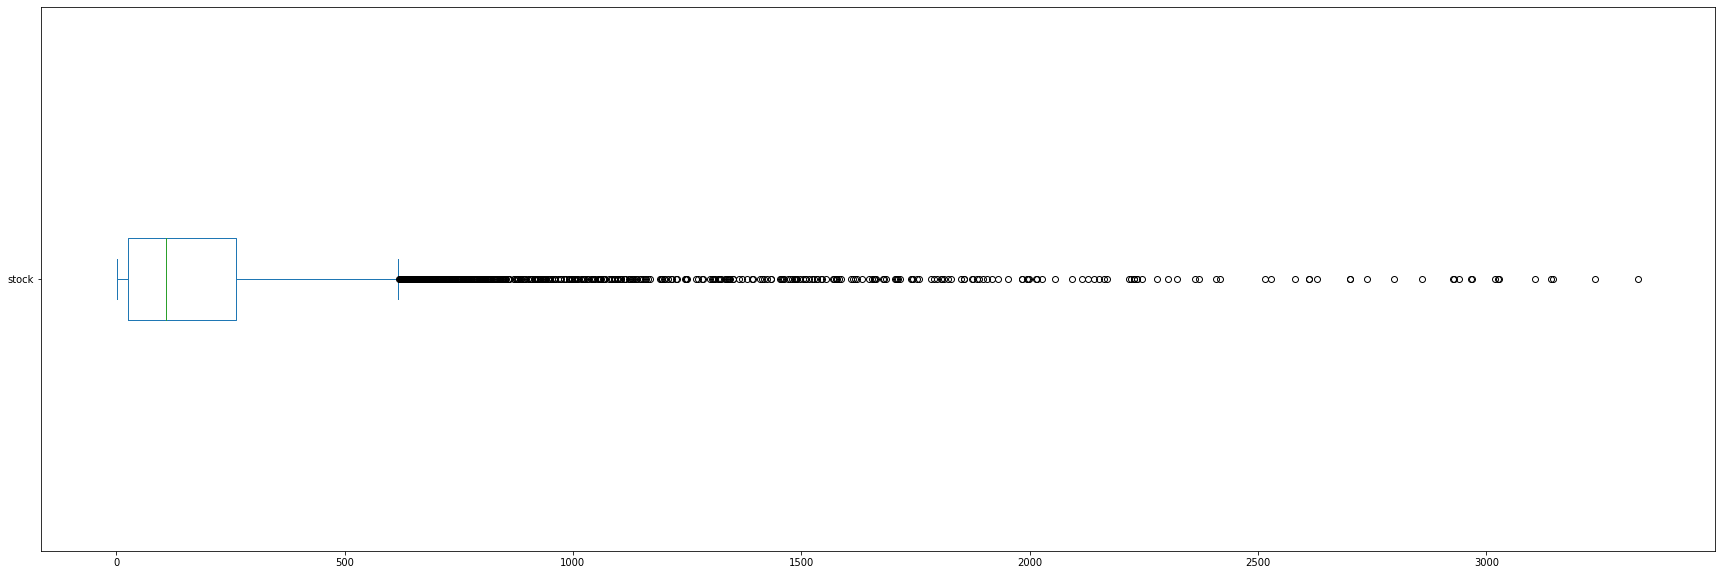

In [20]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

<AxesSubplot:>

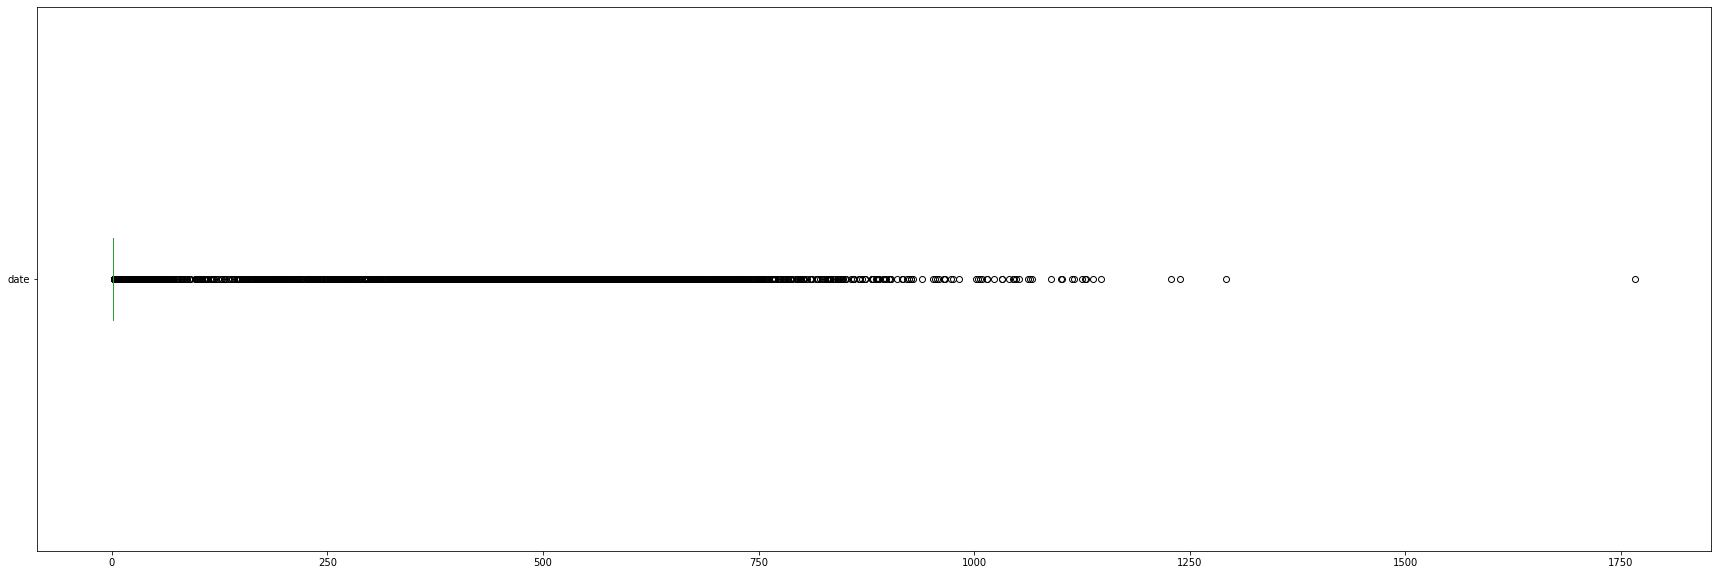

In [21]:
# BocPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

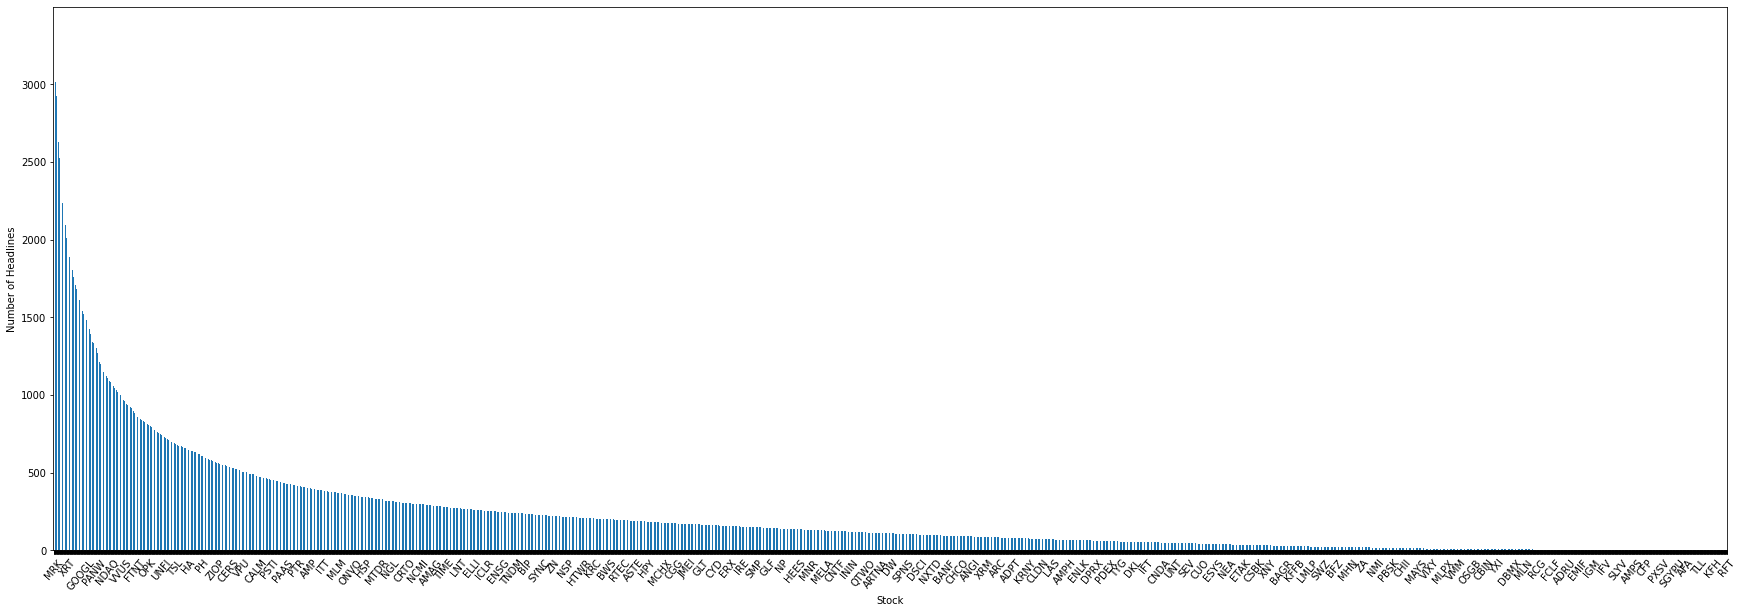

In [22]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

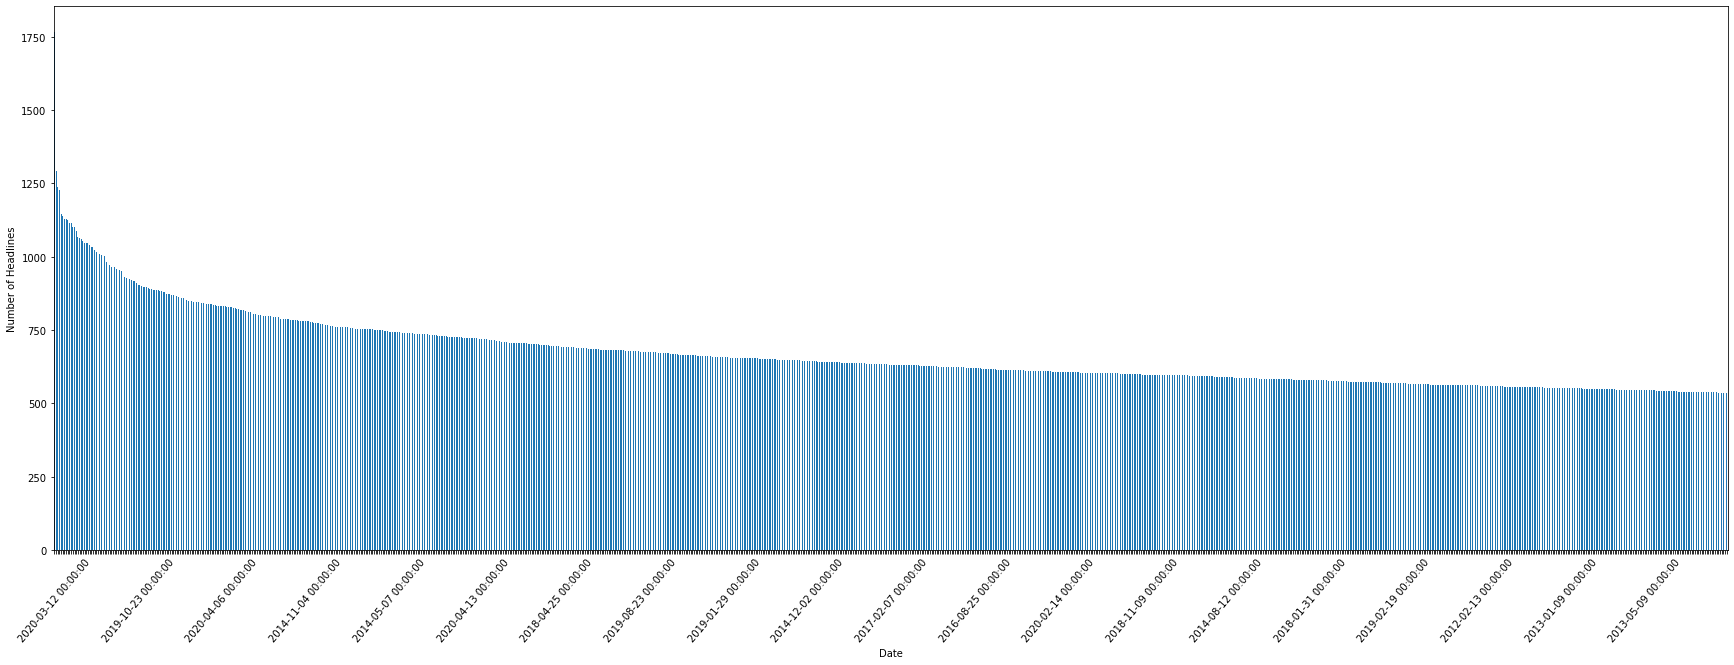

In [23]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [24]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

In [25]:
print("Der Datensatz erstreckt sich über einen Datumsspanne vom "+ data['date'].min()[0:10] +" bis zum "+ data['date'].max()[0:10] +"\nDabei besteht der Datensatz aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich über einen Datumsspanne vom 2009-02-14 bis zum 2020-06-11
Dabei besteht der Datensatz aus 1407328 Einträgen


Text(0, 0.5, 'Number of Healines')

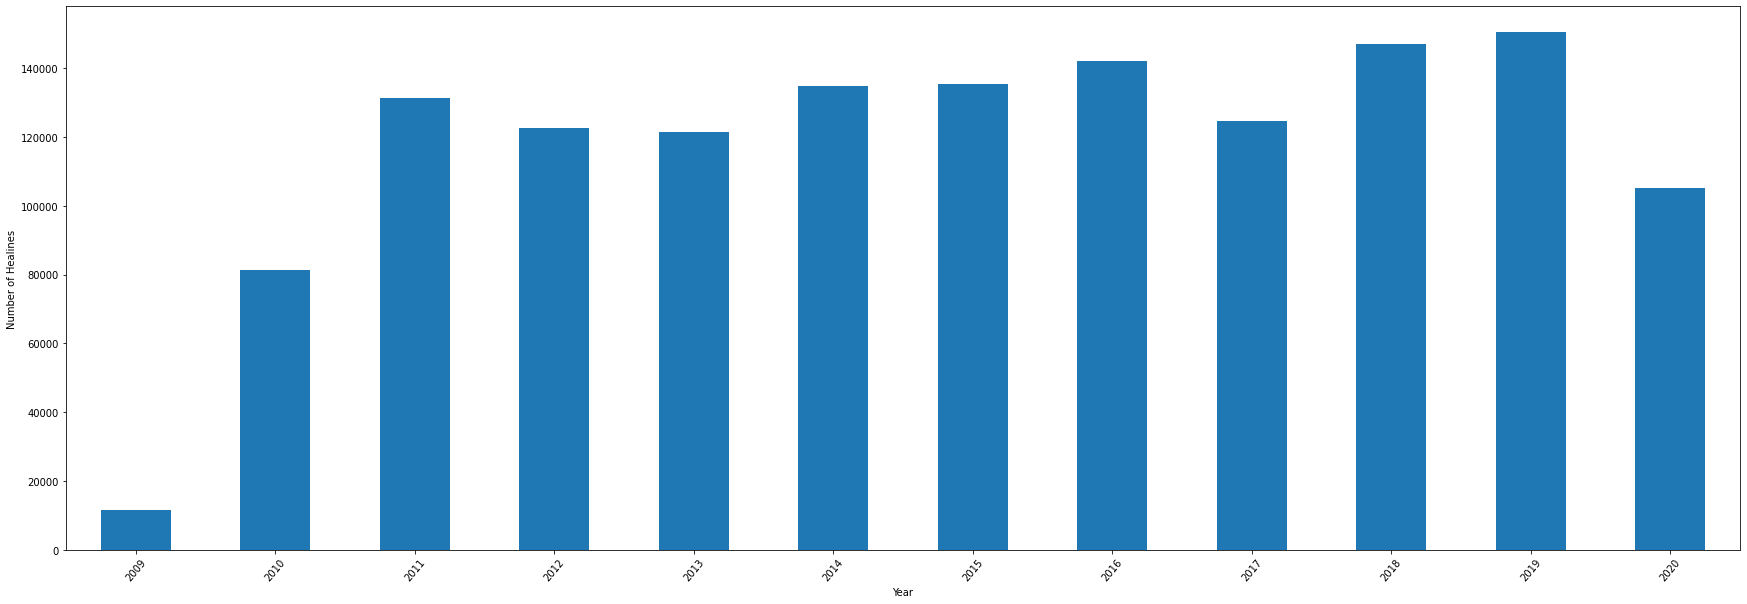

In [26]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [27]:
import statistics

print(statistics.mean(year.size()))

117277.33333333333


In [28]:
# Termdocument Matrix

# all headlines as String in List
docs = []
for headline in data.headline:
    docs.append(headline)
docs = docs[0:1000]

vec = CountVectorizer()
X = vec.fit_transform(docs)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df)

# !! TDM just useful for stemmend and removed Stopwords dataset

     00  000  014b  015b  01b  01m  02b  02m  03  03b  ...  yo  you  young  \
0     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
1     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
2     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
3     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
4     0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
..   ..  ...   ...   ...  ...  ...  ...  ...  ..  ...  ...  ..  ...    ...   
995   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
996   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
997   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
998   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   
999   0    0     0     0    0    0    0    0   0    0  ...   0    0      0   

     your  yoy  yum  zacks  zoll  zone  zoom  
0       0    0  

#### Wordclouds before Data Cleaning

WorldCloud over all Stocks, Top 50 Words:


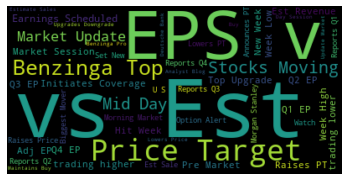

In [29]:
# Wordcloud for all Headlines

#combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50
#wordcloud
#!! No Stopword removal
# stopwords = STOPWORDS
# stopwords.update(["Benzinga", "Stocks", "vs", "Est", "EPS"])
wordcloud = WordCloud(max_words=maxWords).generate(text)

#plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud.png")

WorldCloud for Random Stock: VCF, Top 50 Words:


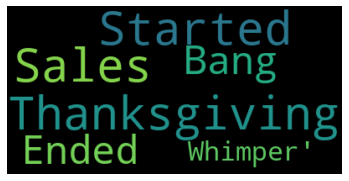

In [30]:
# Wordcloud for one Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

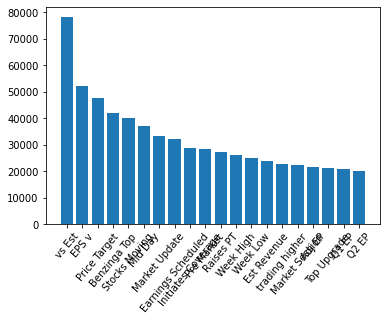

In [31]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

#### Topic Modelling before Data Cleaning

In [32]:
# Topic Modelling with topicCount Topics
topicCount = 10

## Necessary Text Cleaning
# Remove punctuation
# data['headline_processed'] = \
# data['headline'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
# data['headline_processed'] = \
# data['headline_processed'].map(lambda x: x.lower())

# stop_words = stopwords.words('english')
# stop_words.extend(['bezinga', 'stock'])

## Necessary Tokenzisation of Sentences to Words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stop_words] for doc in texts]


headline = data.headline.values.tolist() #use headline_processed instead of headline for a little bit of DataCleaning
headline_words = list(sent_to_words(headline))
# remove stop words
# headline_words = remove_stopwords(headline_words)

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(headline_words)
# Create Corpus
texts = headline_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [34]:
# The Real Topic Modelling
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=topicCount)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"for" + 0.041*"earnings" + 0.040*"week" + 0.032*"stocks" + '
  '0.029*"new" + 0.028*"scheduled" + 0.025*"of" + 0.020*"which" + 0.018*"set" '
  '+ 0.018*"the"'),
 (1,
  '0.056*"up" + 0.044*"from" + 0.038*"down" + 0.026*"to" + 0.023*"movers" + '
  '0.016*"biggest" + 0.015*"etfs" + 0.013*"benzinga" + 0.013*"yesterday" + '
  '0.012*"etf"'),
 (2,
  '0.048*"for" + 0.047*"to" + 0.033*"of" + 0.019*"in" + 0.013*"and" + '
  '0.012*"with" + 0.010*"watch" + 0.008*"announces" + 0.008*"the" + '
  '0.007*"says"'),
 (3,
  '0.048*"at" + 0.026*"announces" + 0.026*"on" + 0.025*"alert" + '
  '0.025*"option" + 0.018*"initiates" + 0.018*"coverage" + 0.016*"ask" + '
  '0.015*"oi" + 0.015*"trade"'),
 (4,
  '0.037*"to" + 0.035*"the" + 0.035*"shares" + 0.024*"of" + 0.023*"share" + '
  '0.022*"after" + 0.019*"trading" + 0.017*"company" + 0.015*"are" + '
  '0.014*"from"'),
 (5,
  '0.094*"to" + 0.060*"on" + 0.037*"pt" + 0.031*"buy" + 0.029*"raises" + '
  '0.029*"maintains" + 0.026*"target" + 0.025*"p

In [35]:
# Visualization of the Topic Modelling

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./app/results_ldavis_prepared_'+str(topicCount))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './app/results_ldavis_prepared_'+ str(topicCount) +'.html')
LDAvis_prepared

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.086189  0.007155       1        1  18.546371
7      0.148918  0.075543       2        1  13.763551
5     -0.230047  0.191258       3        1  13.066719
8     -0.176993 -0.279688       4        1   9.488822
6      0.159535  0.019887       5        1   9.234937
1      0.058299  0.110259       6        1   8.107857
4     -0.002763  0.045153       7        1   8.046875
9      0.070526 -0.006758       8        1   7.563578
0      0.079996 -0.211580       9        1   6.777586
3     -0.193661  0.048770      10        1   5.403704, topic_info=        Term           Freq          Total Category  logprob  loglift
297       vs  167717.000000  167717.000000  Default  30.0000  30.0000
295      est  145688.000000  145688.000000  Default  29.0000  29.0000
35       eps  132298.000000  132298.000000  Default  28.0000  28.0000
4     stocks  157849.000000  157849.000000  Default  27.0000  27.0000
25        to  432153.000000  432153.000000  Default  26.0000  26.0000
...      ...            ...            ...      ...      ...      ...
19        of    8769.840634  284277.689515  Topic10  -4.4955  -0.5605
43       the    6923.158037  215743.911404  Topic10  -4.7319  -0.5211
810       pt    5721.488739   77575.365832  Topic10  -4.9226   0.3111
1851  energy    4670.517709   42426.418375  Topic10  -5.1255   0.7116
266      inc    4607.305394   46994.849706  Topic10  -5.1392   0.5957

[894 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
463        1  0.818841  acquire
463        2  0.014462  acquire
463        3  0.010433  acquire
463        4  0.047104  acquire
463        5  0.001240  acquire
...      ...       ...      ...
13190      5  0.971687     zagg
13190      7  0.018611     zagg
13190      9  0.009795     zagg
10754      7  0.999372     zika
7706      10  0.999582    zynga

[4260 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 6, 9, 7, 2, 5, 10, 1, 4])

### Data Quality

In [36]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))

Anzahl von null Werten im gesamten DataFrame: 0


In [37]:
# count all dates without time, no need to format in isoFormat
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))

Anzahl Zeitstempel ohne konkrete Uhrzeit: 1351341


In [38]:
# count duplicated
print("Anzahl Doppelten Einträgen: "+ str(data.duplicated().sum()))

Anzahl Doppelten Einträgen: 0


## Data Preparation

### Clean

#### Date Cleaning

In [39]:
# format datetime to date
data = data.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

# delete all rows older than 2years, because of API and Performance
data = data.drop(data[data.date < '2019-08-21'].index)


In [40]:
# clean the Stocks
# Remove Rows with Stocks that occur less than occ times
occ = 0
data = data[data.groupby('stock').stock.transform(len) > occ]

In [41]:
print("Der Datensatz erstreckt sich nun über einen Datumsspanne vom "+ data['date'].min() +" bis zum "+ data['date'].max() +"\nDabei besteht der Datensatz jetzt aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich nun über einen Datumsspanne vom 2019-08-21 bis zum 2020-06-11
Dabei besteht der Datensatz jetzt aus 164698 Einträgen


#### Headline Cleaning & Pre-Processing
Hier wird nochmal speziell jede einzelene Headline mit WordNet den typischen pre-processing Schritten unterzogen

In [42]:
#POS Tagging
#Beim Part Of Speech Tagging wird geprüft, ob es sich um ein Nomen, Adjevtiv etc. handelt. Das unterstützt das Lammatisieren

def tokenize_post(headline):
    hl_tokenz = word_tokenize(headline)
    hl_post = nltk.pos_tag(hl_tokenz)
    hl_post_result = []
    for word in hl_post:
        if word[1].startswith('NN'):
            hl_post_result.append([word[0], 'n'])
        elif word[1].startswith('JJ'):
            hl_post_result.append([word[0], 'a'])
        elif word[1].startswith('V'):
            hl_post_result.append([word[0], 'v'])
        elif word[1].startswith('R'):
            hl_post_result.append([word[0], 'r'])
        else:
            hl_post_result.append([word[0], ''])
    return hl_post_result


In [43]:
#Tokenization und POS-Tagging durchführen
data['headline_cleaned'] = data['headline'].apply(tokenize_post)

CC coordinating conjunction
CD cardinal digit
DT determiner
EX existential there (like: “there is” … think of it like “there exists”)
FW foreign word
IN preposition/subordinating conjunction
JJ adjective ‘big’
JJR adjective, comparative ‘bigger’
JJS adjective, superlative ‘biggest’
LS list marker 1)
MD modal could, will
NN noun, singular ‘desk’
NNS noun plural ‘desks’
NNP proper noun, singular ‘Harrison’
NNPS proper noun, plural ‘Americans’
PDT predeterminer ‘all the kids’
POS possessive ending parent’s
PRP personal pronoun I, he, she
PRP$ possessive pronoun my, his, hers
RB adverb very, silently,
RBR adverb, comparative better
RBS adverb, superlative best
RP particle give up
TO, to go ‘to’ the store.
UH interjection, errrrrrrrm
VB verb, base form take
VBD verb, past tense took
VBG verb, gerund/present participle taking
VBN verb, past participle taken
VBP verb, sing. present, non-3d take
VBZ verb, 3rd person sing. present takes
WDT wh-determiner which
WP wh-pronoun who, what
WP$ possessive wh-pronoun whose
WRB wh-abverb where, when

In [44]:
#funktionen für Lowercase und Stopword-removal

#alle pos-tagged wörter der headlines werden jetzt nochmal kleingeschrieben
def lowercase(headline_post_tok):
    hl_post_tok_lower = []
    for word_pos in headline_post_tok:
        hl_post_tok_lower.append(tuple([word_pos[0].lower(), word_pos[1]]))
    return hl_post_tok_lower
    
#Stopwords aus dem NLTK Modul nehmen und entfernen
def remove_stopwords(hl_post_tok_lower):
    stop_words = set(stopwords.words('english')) 

    #hier könnte man noch ein paar eigene Stopwords hinzufügen
    # stop_words.add('')

    filtered_sentence = [word for word in hl_post_tok_lower if not word[0] in stop_words]
    return filtered_sentence

In [45]:
#Headlines lowercase machen und danach anzeigen
data['headline_cleaned'] = data['headline_cleaned'].apply(lowercase)

In [46]:
#jetzt das stopword removal durchführen
data['headline_cleaned'] = data['headline_cleaned'].apply(remove_stopwords)

In [47]:
#Hier eine Lemmatisierungsfunktion mit dem WortNetLemmatizer
lemmatizer = WordNetLemmatizer()

#this headline is pos-tagged, tokenzied, lower, and stopwords-removed
def lemmatize(headline):
    lemmatized_output = []
    for word in headline:
        if word[1] == '':
            lemmatized_output.append((lemmatizer.lemmatize(word[0]), word[1]))
        else:
            lemmatized_output.append((lemmatizer.lemmatize(word[0], pos=word[1]), word[1]))

    #Alle Wörter mit weniger als zwei Zeichen weg
    lemmatized_output = [word for word in lemmatized_output if len(word[0]) > 2]

    #Alle Zahlen entfernen
    lemmatized_output = [word for word in lemmatized_output if not word[0].isnumeric()]

    return lemmatized_output

In [48]:
#lemmatization durchführen

#nächste Zeile um daten zu laden
# data_important = pd.read_csv('../data/zwischenergebnis_stopwords_tokenized.csv')
data['headline_cleaned'] = data['headline_cleaned'].apply(lemmatize)

In [49]:
#Mit ein Synset ist eine Liste von den gebräuchlisten Synonymen für ein Wort. zu jedem Wort nehmen wir das gebräuchliste Synonym, um möglichst viele Senitment Werte zu bekommen.
def getSynset(headline):
    synset_output = []
    for word in headline:
        synsets = wn.synsets(word[0], pos=word[1])
        if len(synsets)>0:
            synset_output.append((synsets[0].name()))
        # wort entfernen wenn kein senitment verfügbar
        # else:
        #     synset_output.append(word[0]+ "." +word[1]+".01")
    return synset_output

In [50]:
#Synset berechnen
data['headline_cleaned'] = data['headline_cleaned'].apply(getSynset)

In [51]:
#calculate sentiment
nltk.download('sentiwordnet')
senti_pos_score = []
senti_neg_score = []

senti_score = []
# senti_obj_score = []

def getSentiment(headline):
    senti_pos = 0
    senti_neg = 0
    # senti_obj = 0
    for word in headline:
        swn_synset = swn.senti_synset(word)
        senti_pos += swn_synset.pos_score()
        senti_neg += swn_synset.neg_score()

    senti_pos_score.append(senti_pos)
    senti_neg_score.append(senti_neg)

    senti_score.append(senti_pos - senti_neg)
    # senti_obj_score.append(swn_synset.obj_score())
    return headline

[nltk_data] Downloading package sentiwordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [52]:
# calculate Sentiment
data['headline_cleaned'] = data['headline_cleaned'].apply(getSentiment)

In [53]:
# add Sentiment to DataFrame
data['senti_pos_score'] = senti_pos_score
data['senti_neg_score'] = senti_neg_score

data['senti_score'] = senti_score

In [54]:
data.sample(7)

id                                           headline  \
1119345  1124853           Stocks That Hit 52-Week Highs On Tuesday   
402599    404791                   70 Biggest Movers From Yesterday   
952019    956840  Mid-Afternoon Market Update: Dow Rises Over 50...   
1264689  1270692  TELUS Shares Unaffected Following Press Releas...   
71728      72406  Amkor Technology shares are trading lower. Not...   
222820    224239  UPDATE: Wells Fargo Initiates Clear Channel Ou...   
887022    891541  DA Davidson Maintains Neutral on Nordson, Lowe...   

                                                       url          publisher  \
1119345  https://www.benzinga.com/news/20/02/15247386/s...         Lisa Levin   
402599   https://www.benzinga.com/news/20/04/15862690/7...         Lisa Levin   
952019   https://www.benzinga.com/news/19/09/14475415/m...         Lisa Levin   
1264689  https://www.benzinga.com/news/19/09/14483700/t...  Benzinga Newsdesk   
71728    https://www.benzinga.com/wiim/19/11/14858157/a...  Benzinga Newsdesk   
222820   https://www.benzinga.com/analyst-ratings/analy...  Benzinga_Newsdesk   
887022   https://www.benzinga.com/news/19/08/14304681/d...         Vick Meyer   

               date stock                                   headline_cleaned  \
1119345  2020-02-04    SF    [stock.n.01, hit.v.01, high.n.01, tuesday.n.01]   
402599   2020-04-23  ECPG           [large.a.01, mover.n.01, yesterday.n.01]   
952019   2019-09-23  ONTX  [market.n.01, update.n.01, rise.v.01, point.n....   
1264689  2019-09-24    TU  [share.n.01, following.n.01, imperativeness.n....   
71728    2019-11-21  AMKR  [technology.n.01, share.n.01, trade.v.01, see....   
222820   2019-09-24   CCO  [update.n.01, well.n.01, fargo.n.01, novice.n....   
887022   2019-08-21  NDSN  [neutral.n.01, lower_berth.n.01, monetary_valu...   

         senti_pos_score  senti_neg_score  senti_score  
1119345            0.125            0.000        0.125  
402599             0.250            0.125        0.125  
952019             0.000            0.000        0.000  
1264689            0.125            0.000        0.125  
71728              0.500            0.250        0.250  
222820             1.375            0.000        1.375  
887022             0.000            0.250       -0.250

In [55]:
#Export as csv for faster access
data.to_csv('../data/analyst_ratings_processed_hl_cleaned.csv', index=False)

### Construct

#### API call to get StockPrices for all stocks that occur more than 10 times
used API : 'https://polygon.io/'
(need timeouts because of max 5 Api calls per Minute)

In [56]:
# List of Stock Ticker to call
stocks_unique = unique(data['stock'])
print("Es verbleiben "+str(len(stocks_unique))+" eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen")

Es verbleiben 3807 eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen


In [ ]:
# API call with TimeOut (5 per minute)
key = os.environ.get("POLYGON_IO_API_KEY")
apiResults = []
apiCount = 0

for s in stocks_unique:
    # the API only response to 2years historical dates
    from_ = '2019-08-21'
    to =  '2020-12-31'

    #The API call
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(s, 1, "day", from_, to, unadjusted=False)
        # save the nessecary attributes of the JSON as List
        if (resp and hasattr(resp, 'results')):
            for result in resp.results:
                dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
                apiResults.append([s, dt, result['o'], result['h'], result['l'], result['c']])
        else: 
            apiResults.append([s])
            print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___no_Results___")
    apiCount+=1
    print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___success___")
    time.sleep(12)

#save the List-Data as DataFrame
stock_prices = pd.DataFrame(apiResults, columns=['stock', 'date', 'open', 'high', 'low', 'close'])
#save the DataFrame as csv
stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

In [57]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

#### Overview of the API Data

Remove Stocks that has no Results from DataFrame Stock_prices and Data

In [58]:
stock_prices.count()

stock    1227563
date     1227498
open     1227498
high     1227498
low      1227498
close    1227498
dtype: int64

In [59]:
stock_prices.sample(7)

stock                 date   open    high    low  close
810380      O  2019-12-26T06:00:00  72.47  72.850  72.37  72.84
783182    NOG  2020-12-15T06:00:00   8.53   8.725   8.05   8.67
796875   NUVA  2019-11-18T06:00:00  73.28  73.920  72.27  72.59
597389    JBL  2020-04-02T06:00:00  22.75  23.440  22.08  22.86
1209296   XLB  2020-03-26T05:00:00  44.38  46.140  44.29  45.92
540218   HYEM  2020-12-15T06:00:00  23.70  23.800  23.70  23.73
1089685   TOT  2020-12-18T06:00:00  44.09  44.270  43.49  43.57

In [60]:
# count NaN rows
nanStocks = stock_prices[stock_prices['open'].isna() & stock_prices['close'].isna()]['stock']
print("Total Count of Stocks with NaN: " + str(len(nanStocks)))

Total Count of Stocks with NaN: 65


#### Combine DataFrame

open and close price of the Stock

In [61]:
# remove headlines with NaN stock prices
data = data.drop(data[data['stock'].isin(nanStocks)].index)

# remove NaN stocks
stock_prices = stock_prices.drop(stock_prices[stock_prices.open.isna() & stock_prices.close.isna()].index)

In [62]:
# format datetime to date
stock_prices = stock_prices.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

In [63]:
# remove headlines with date that are not covered by the stockprices -> probably Weekend
# datetime.datetime.fromisoformat().weekday() in [5,6]
data = data.drop(data[~data['date'].isin(stock_prices['date'])].index) # ~ means NOT IN

In [64]:
stock_prices.isna().sum()

stock    0
date     0
open     0
high     0
low      0
close    0
dtype: int64

In [65]:
data = pd.merge(data, stock_prices[['stock', 'date', 'open', 'close']], on=['stock', 'date'])

### Format

Datetime Format already done for requesting the API and Merging the DateFrames<br>
No more formating needed

## Export Cleaned and Merged DataFrame

In [67]:
# export final DataSet as csv
data.to_csv('../data/analyst_ratings_processed_final.csv', index=False)

In [68]:
# import final DataSet for Modelling
data = pd.read_csv('../data/analyst_ratings_processed_final.csv')

## Data Understanding: Visualization after Cleaning

#### Overview of the Final DataFrame

In [69]:
print(data.columns)
data.sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_cleaned', 'senti_pos_score', 'senti_neg_score', 'senti_score',
       'open', 'close'],
      dtype='object')


id                                           headline  \
14578    115645  BMO Capital Maintains Market Perform on Broadc...   
142588  1256263  Shares of several energy companies are trading...   
161054  1408125  Shares of several healthcare companies are tra...   
159928  1394449  HP Sends Letter to Xerox; Says Xerox's Proposa...   
127422  1116744  The Walt Disney Company Sells Its Interest in ...   
147670  1285985  Benzinga's Top Upgrades, Downgrades For Septem...   
75459    657859  Independence Holding Q1 EPS $0.290 Down From $...   

                                                      url          publisher  \
14578   https://www.benzinga.com/news/19/12/14988040/b...  Benzinga_Newsdesk   
142588  https://www.benzinga.com/20/04/15848145/shares...  Benzinga Newsdesk   
161054  https://www.benzinga.com/wiim/20/04/15749338/s...  Benzinga Newsdesk   
159928  https://www.benzinga.com/m-a/20/01/15096604/hp...      Charles Gross   
127422  https://www.benzinga.com/news/19/08/14352801/t...  Benzinga Newsdesk   
147670  https://www.benzinga.com/analyst-ratings/upgra...         Lisa Levin   
75459   https://www.benzinga.com/news/earnings/20/05/1...  Benzinga Newsdesk   

              date stock                                   headline_cleaned  \
14578   2019-12-13  AVGO  ['capital.n.01', 'market.n.01', 'raise.n.01', ...   
142588  2020-04-21   TRP  ['share.n.01', 'several.s.01', 'energy.n.01', ...   
161054  2020-04-06  ZIOP  ['share.n.01', 'several.s.01', 'healthcare.n.0...   
159928  2020-01-09   XRX  ['letter.n.01', 'xerox.n.01', 'say.n.01', 'xer...   
127422  2019-08-29  SBGI  ['disney.n.01', 'company.n.01', 'sell.n.01', '...   
147670  2019-09-10   UBS  ['top.n.01', 'ascent.n.01', 'downgrade.n.01', ...   
75459   2020-05-07   IHC  ['independence.n.01', 'retention.n.01', 'sale....   

        senti_pos_score  senti_neg_score  senti_score    open   close  
14578             0.000            0.000        0.000  318.06  315.42  
142588            0.625            2.000       -1.375   42.77   44.40  
161054            1.250            1.625       -0.375    2.38    2.61  
159928            0.125            0.000        0.125   36.06   36.60  
127422            0.625            0.250        0.375   44.32   44.25  
147670            0.000            0.000        0.000   11.57   11.49  
75459             0.000            0.000        0.000   27.26   27.64

In [70]:
count_zeroSenti = data[data['senti_score'] == 0.000]['id'].count()
count_noSenti = data[(data['senti_pos_score'] == 0.000) & (data['senti_neg_score'] == 0.000)]['id'].count()
count_Senti = data[data['senti_score'] != 0.000]['id'].count()
count_Senti_neg = data[data['senti_score'] < 0.000]['id'].count()
count_Senti_pos = data[data['senti_score'] > 0.000]['id'].count()
count_eachSenti = data[(data['senti_pos_score'] != 0.000) & (data['senti_neg_score'] != 0.000)]['id'].count()

print("Im folgenden wird die Verteilung des Sentiment-Score über die Headlines genauer betrachtet: \n%d headlines haben einen durchschnittlichen Sentiment von 0, davon haben %d weder einen positiven noch einen negativen Sentiment-Score. \nHingegegen haben %d Headlines einen Sentiment-Score gesetzt der ungleich 0 ist. %d positive, %d negative. Dabei haben %d jeweils positive und negative zu bewertende Wörter." % (count_zeroSenti,count_noSenti,count_Senti,count_Senti_neg,count_Senti_pos,count_eachSenti))

Im folgenden wird die Verteilung des Sentiment-Score über die Headlines genauer betrachtet: 
64456 headlines haben einen durchschnittlichen Sentiment von 0, davon haben 59718 weder einen positiven noch einen negativen Sentiment-Score. 
Hingegegen haben 97022 Headlines einen Sentiment-Score gesetzt der ungleich 0 ist. 45005 positive, 52017 negative. Dabei haben 50671 jeweils positive und negative zu bewertende Wörter.


In [71]:
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))

observations: 161478, features: 12 

unique headlines: 76162, unique stocks: 3722 



<AxesSubplot:>

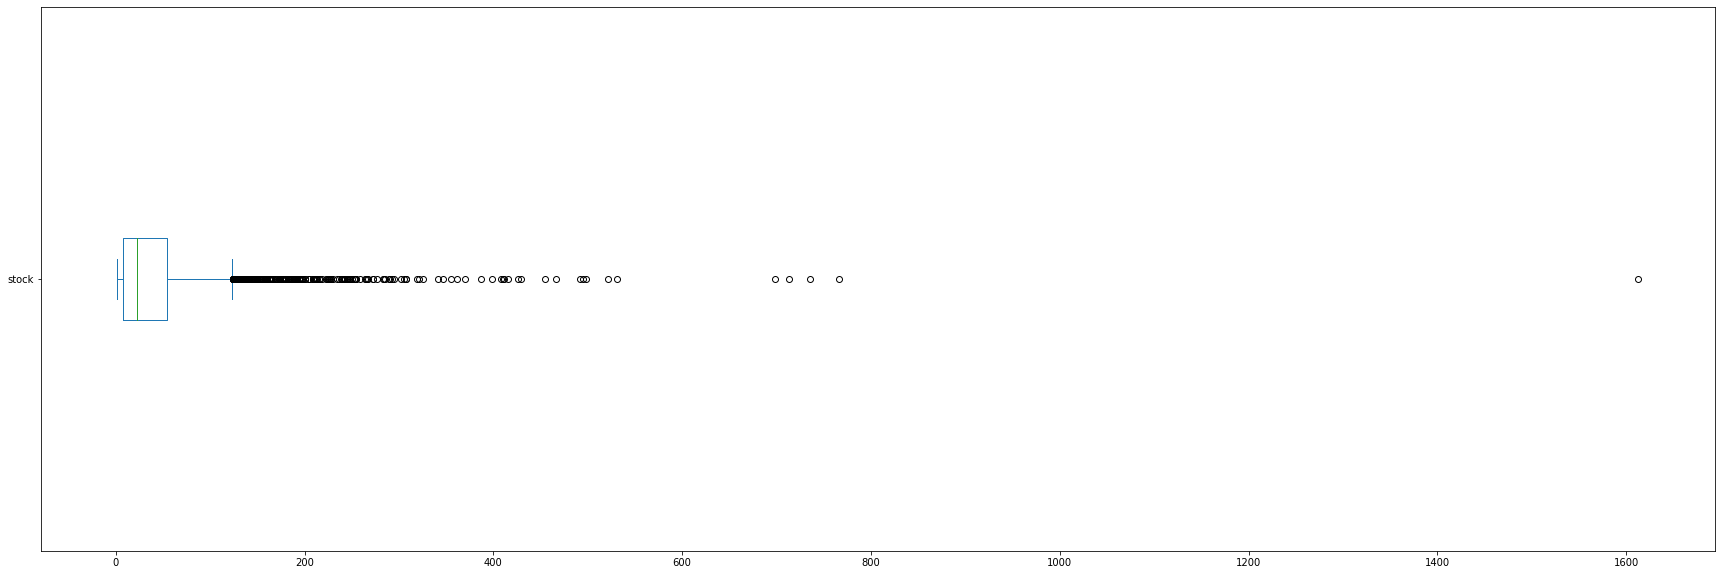

In [72]:
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

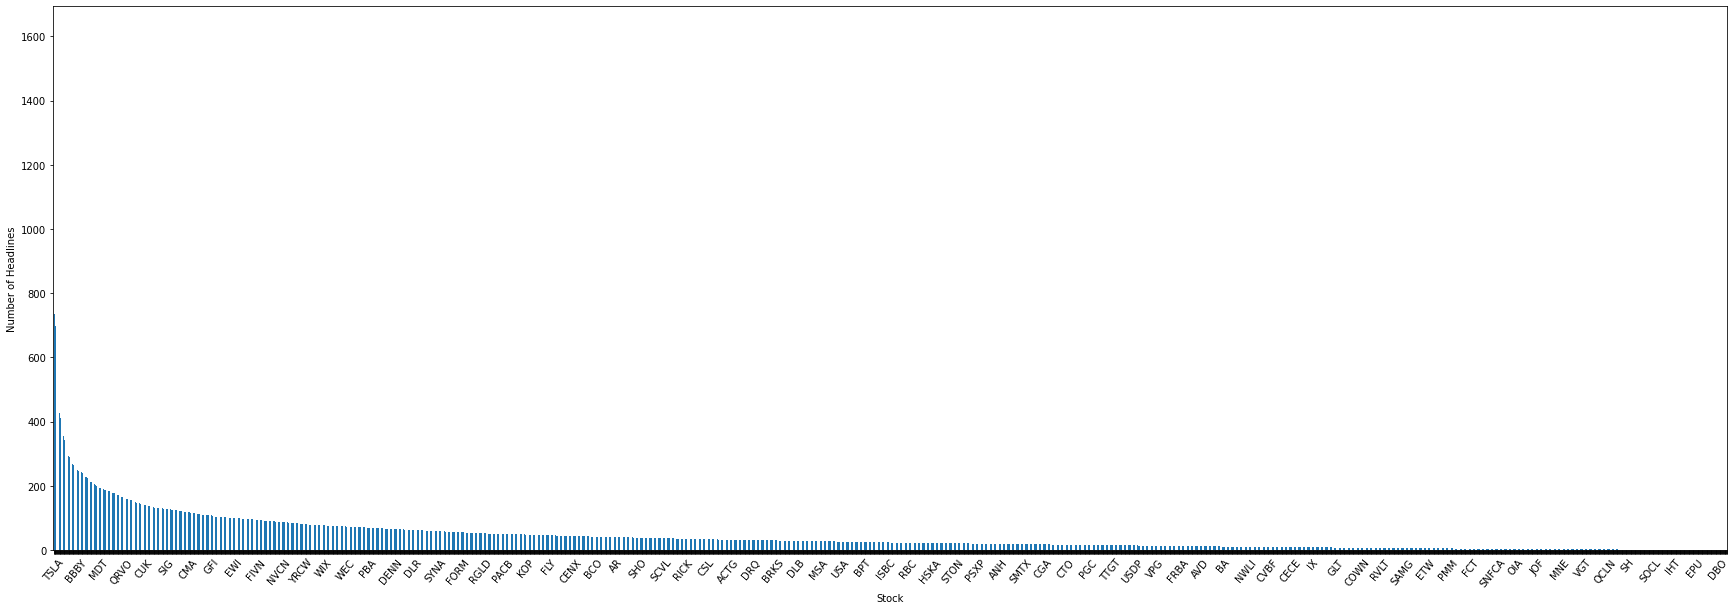

In [73]:
stock = data.groupby("stock")
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

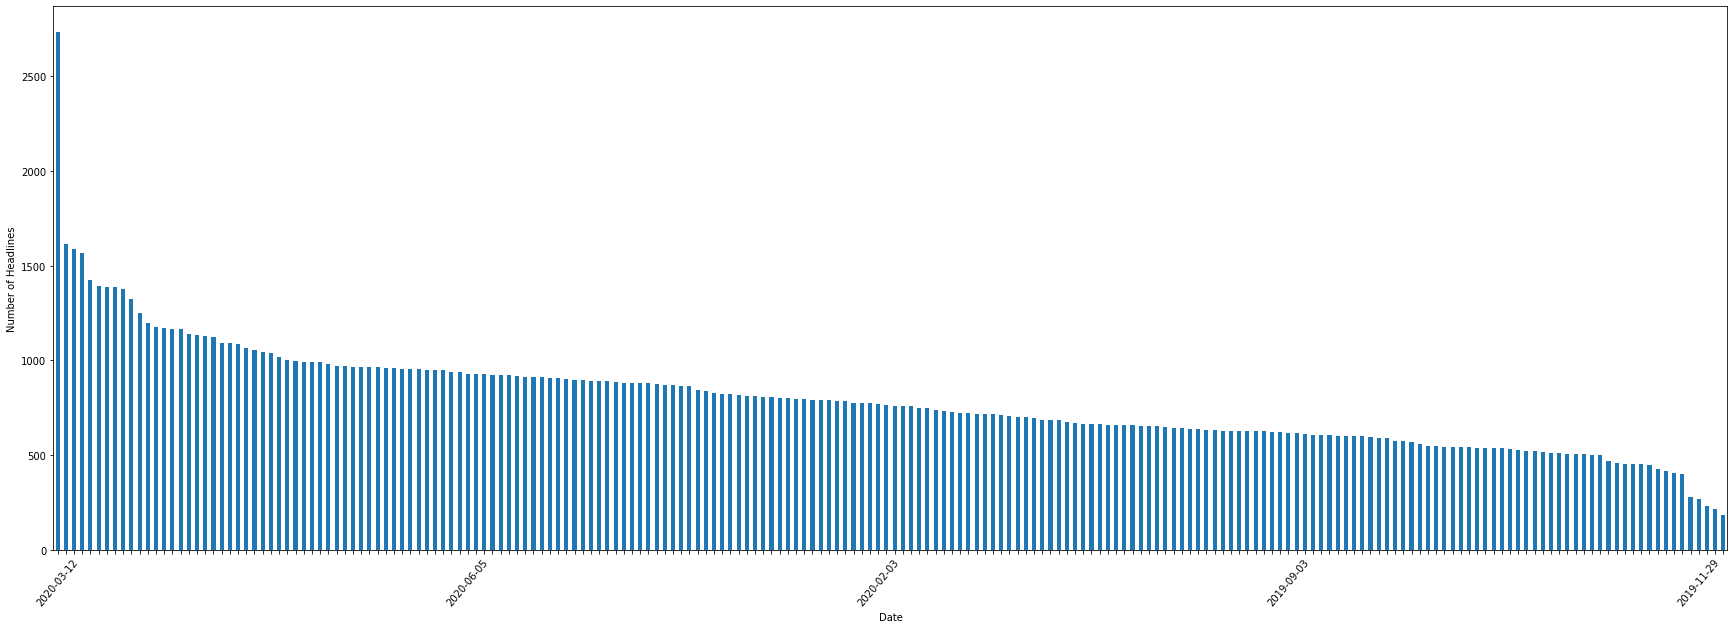

In [74]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [ ]:
# Termdocument Matrix

# all headlines as String in List
docs_afterCleaning = []
for headline in data.headline_cleaned:
    docs.append(headline)

vec = CountVectorizer()
X = vec.fit_transform(docs)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df)

# !! TDM just useful for stemmend and removed Stopwords dataset

#### Wordclouds after Data Cleaning

In [ ]:
# Wordcloud for all Headlines

#combine all headlines to one text
text_afterCleaning = " ".join(headline for headline in data.headline)
maxWords = 50
#wordcloud
#No Stopword removal - Stopwords already removed
# stopwords = STOPWORDS
# stopwords.update(["Benzinga", "Stocks", "vs", "Est", "EPS"])
wordcloud = WordCloud(max_words=maxWords).generate(text_afterCleaning)

#plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_afterCleaning.png")

In [ ]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text_afterCleaning)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

#### Topic Modelling after Data Cleaning

In [55]:
# Topic Modelling with topicCount Topics
topicCount = 10

headline = data.headline.values.tolist()
headline_words = list(sent_to_words(headline))


In [56]:
# Create Dictionary
id2word = corpora.Dictionary(headline_words)
# Create Corpus
texts = headline_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# The Real Topic Modelling
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=topicCount)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualization of the Topic Modelling

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./app/results_ldavis_prepared_'+str(topicCount))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './app/results_ldavis_prepared_'+ str(topicCount) +'.html')
LDAvis_prepared